## Overview
This tutorial has been prepared by Alex Bonnet, ML Solutions Engineer @ Encord - you might also be interested in checking out our open-source framework for computer vision model testing, evaluation, and validation that you can find here https://github.com/encord-team/encord-active).

This is the notebook which implements the steps discussed in this blog post: https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/

The aim is to take Segment Anything Model and fine tune it to a specific application. We are going to be using the stamp verification dataset https://www.kaggle.com/datasets/rtatman/stamp-verification-staver-dataset since it has data SAM is unlikely to have seen (scans of invoices with stamps), has precise ground truth segmentation masks and also has bounding boxes which we can use as prompts to SAM.

## Set up

In [ ]:
! pip install kaggle &> /dev/null
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

**Action Required:** Place your kaggle.json file into the files in the notebook workspace. More info here https://github.com/Kaggle/kaggle-api#api-credentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rtatman/stamp-verification-staver-dataset

100% 1.86G/1.86G [00:58<00:00, 29.1MB/s]
100% 1.86G/1.86G [00:58<00:00, 34.0MB/s]


In [ ]:
! unzip stamp-verification-staver-dataset.zip &> /dev/null

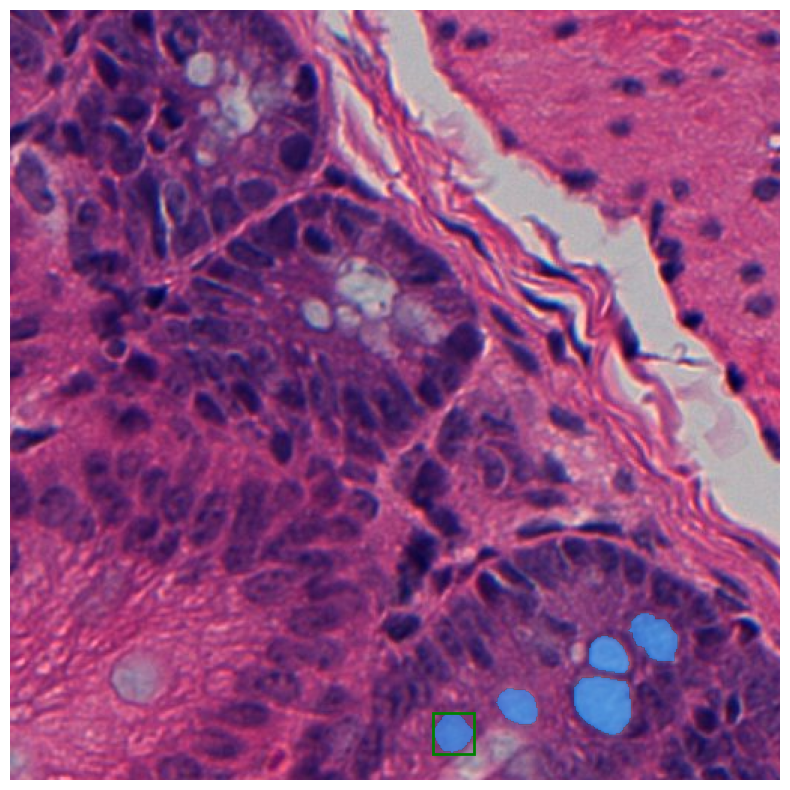

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Exclude scans with zero or multiple bboxes (of the first 100)
stamps_to_exclude = {
}

bbox_coords = {}
for f in sorted(Path('/content/drive/MyDrive/Data Aug/new_mask22').iterdir())[:100]:
  k = f.stem[:-3]
  if k not in stamps_to_exclude:
    im = cv2.imread(f.as_posix())
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    if len(contours) > 1:
      x,y,w,h = cv2.boundingRect(contours[0])
      height, width, _ = im.shape
      bbox_coords[k] = np.array([x, y, x + w, y + h])

ground_truth_masks = {}
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_mask22/{k}-px.tif', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale == 255)

# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

name = 'stampDS-00001'
image = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_raw22/{name}.tif')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()


## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [ ]:
bbox_coords = {}
for f in sorted(Path('/content/drive/MyDrive/Data Aug/new_mask22').iterdir())[:100]:
  k = f.stem[:-3]
  if k not in stamps_to_exclude:
    im = cv2.imread(f.as_posix())
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    if len(contours) > 1:
      x,y,w,h = cv2.boundingRect(contours[0])
      height, width, _ = im.shape
      bbox_coords[k] = np.array([x, y, x + w, y + h])

We extract the ground truth segmentation masks

In [ ]:
ground_truth_masks = {}
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_mask22/{k}-px.tif', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale == 255)

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [ ]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

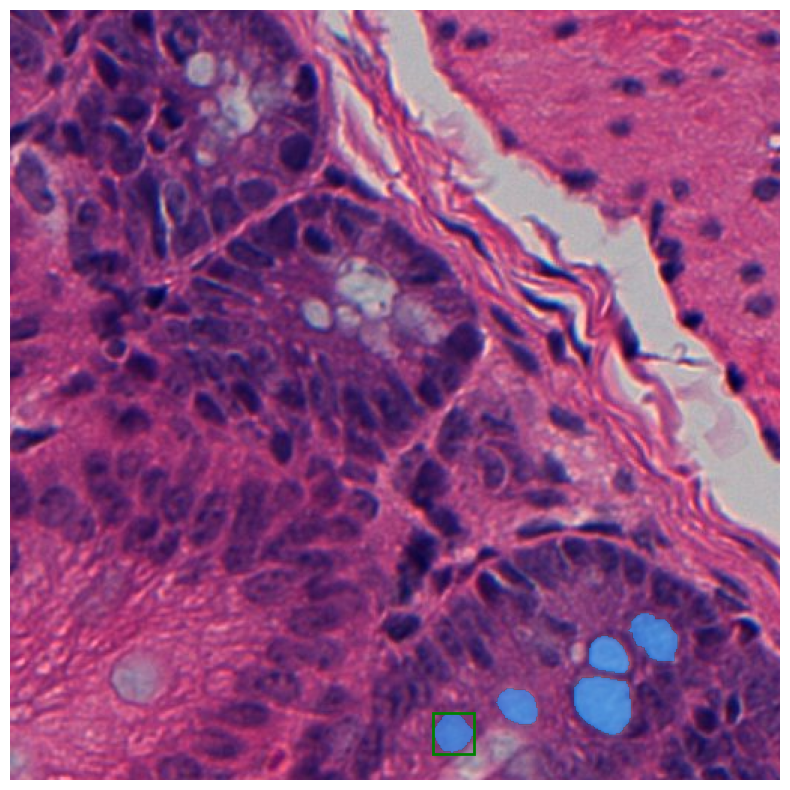

In [ ]:
name = 'stampDS-00001'
image = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_raw22/{name}.tif')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [ ]:
model_type = 'vit_b'
checkpoint = '/content/drive/MyDrive/model/vit-b-lm-fine-tune-1000.pth'
device = 'cuda:0'

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_raw22/{k}.tif')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
# optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)
optimizer = torch.optim.SGD(sam_model.mask_decoder.parameters(), lr=0.01, momentum=0.9)

loss_fn = DiceBCELoss()
# loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

We convert the input images into a format SAM's internal functions expect.

In [ ]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_raw22/{k}.tif')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-5
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)
#optimizer = torch.optim.SGD(sam_model.mask_decoder.parameters(), lr=0.01, momentum=0.9)


loss_fn = DiceBCELoss()
# loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

## Run fine tuning

This is the main training loop.

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [ ]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 500
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in keys[:900]:
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

EPOCH: 0
Mean loss: 1.6692791652679444
EPOCH: 1
Mean loss: 1.669279260635376
EPOCH: 2
Mean loss: 1.6692791652679444
EPOCH: 3
Mean loss: 1.6692792654037476
EPOCH: 4
Mean loss: 1.6692792654037476
EPOCH: 5
Mean loss: 1.669279360771179
EPOCH: 6
Mean loss: 1.6692791700363159
EPOCH: 7
Mean loss: 1.6692792654037476
EPOCH: 8
Mean loss: 1.6692789793014526
EPOCH: 9
Mean loss: 1.6692789697647095
EPOCH: 10
Mean loss: 1.6692788743972777
EPOCH: 11
Mean loss: 1.6692796564102172
EPOCH: 12
Mean loss: 1.6692797565460205
EPOCH: 13
Mean loss: 1.6692798519134522
EPOCH: 14
Mean loss: 1.6692790794372558
EPOCH: 15
Mean loss: 1.6692781114578248
EPOCH: 16
Mean loss: 1.6692780065536499
EPOCH: 17
Mean loss: 1.6692790699005127
EPOCH: 18
Mean loss: 1.6692794609069823
EPOCH: 19
Mean loss: 1.6692795515060426
EPOCH: 20
Mean loss: 1.6692791700363159
EPOCH: 21
Mean loss: 1.669279646873474
EPOCH: 22
Mean loss: 1.6692797422409058
EPOCH: 23
Mean loss: 1.6692795610427857
EPOCH: 24
Mean loss: 1.6692794704437255
EPOCH: 25
Mea

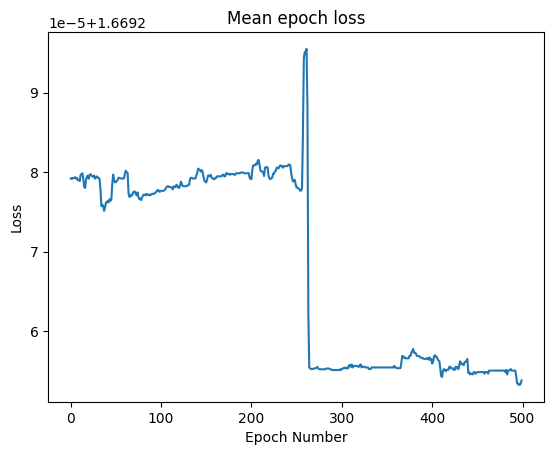

In [ ]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [ ]:
torch.save(sam_model.state_dict(), '/content/drive/MyDrive/model/vit-b-lm-fine-tune-1500.pth')

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[10]
image = cv2.imread(f'/content/drive/MyDrive/Data Aug/new_raw22/{k}.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

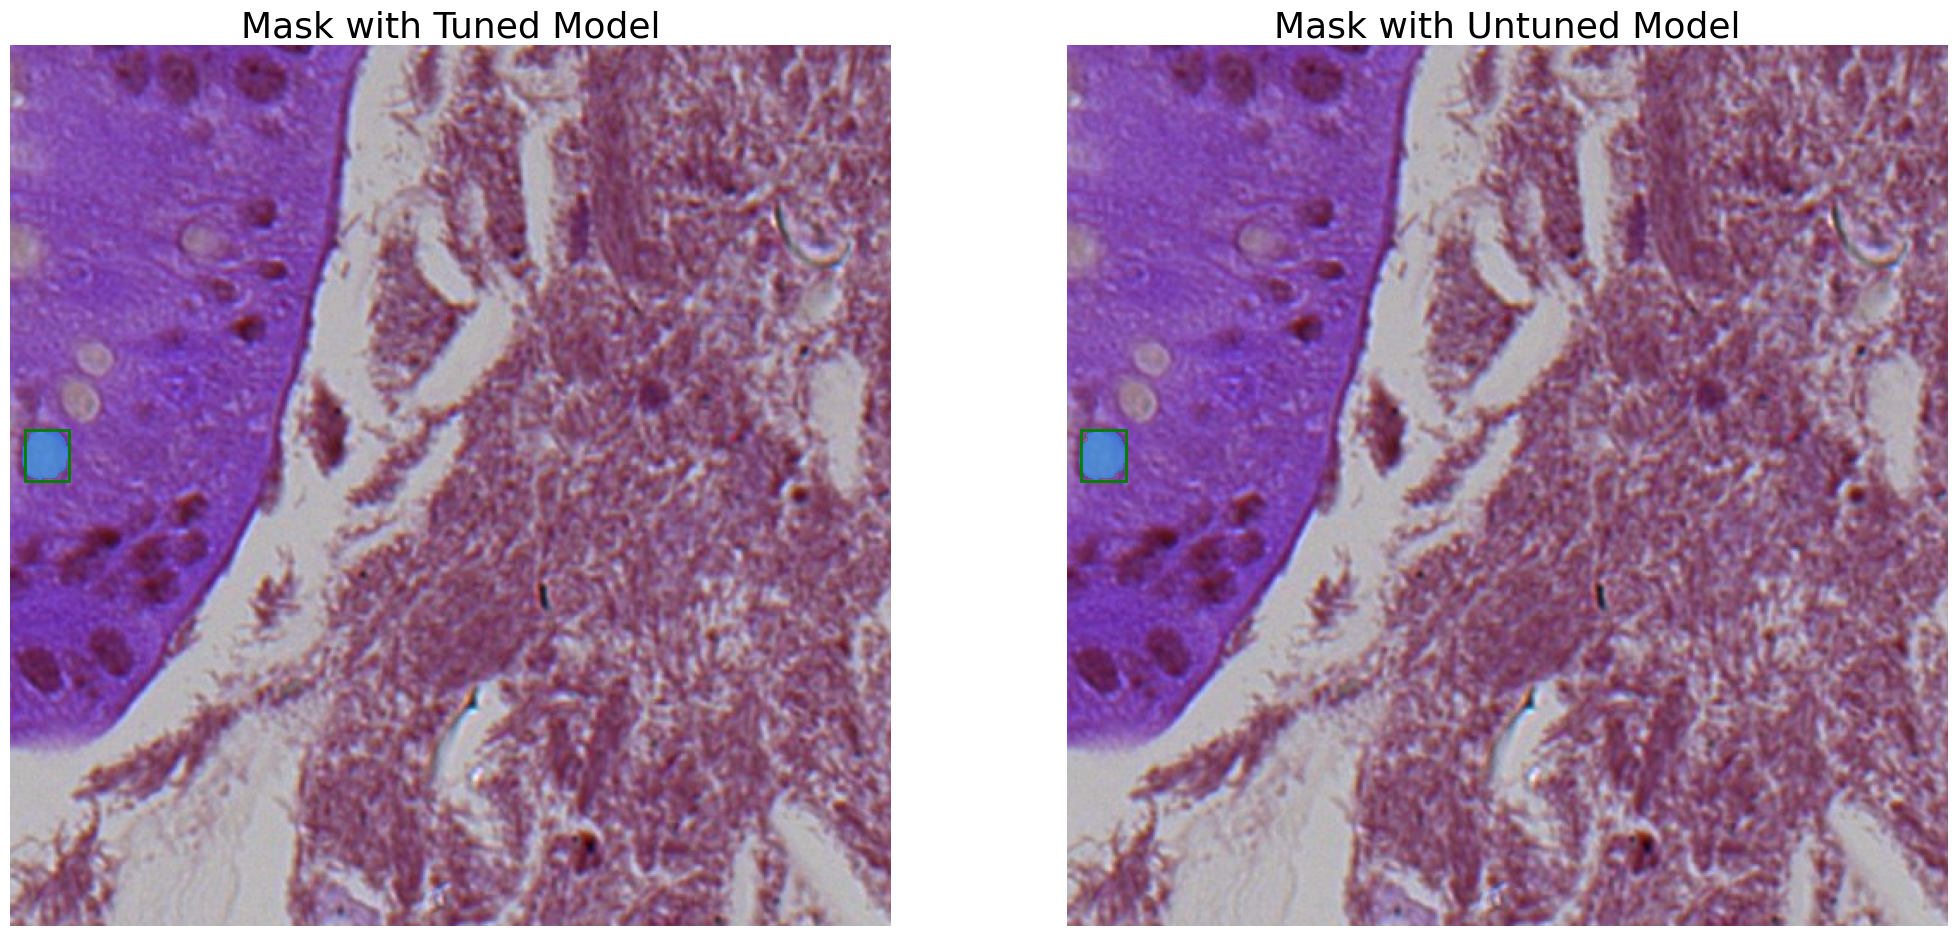

In [ ]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()